<a href="https://colab.research.google.com/github/david-j-cox/NLP_for_VerbalBehavior/blob/master/journal_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Packages we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import zipfile, io, os
import re
from collections import Counter
from itertools import tee, islice
import math
import time
import seaborn as sns
from IPython.display import clear_output
# from google.colab import files
# files.upload()
from google.colab import drive
drive.mount('/content/gdrive')
%cd './gdrive/My Drive/ABAI_2022/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1H1_BJ8S-JaTgDEHfBvIuMCNqz5zQ1ZFy/jaba_nlp/data


# Connect to TPU

In [ ]:
# Connect TPU, if desired
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
clear_output()
print("TPU Connected")

TPU Connected


# Functions

In [ ]:
def ngrams(lst, n):
  tlst = lst
  while True:
    a, b = tee(tlst)
    l = tuple(islice(a, n))
    if len(l) == n:
      yield l
      next(b)
      tlst = b
    else:
      break

def bg_year(df, year):
  temp_df = df[df['years']==year]
  df_str = str([' '.join(temp_df['lemmatization'])])
  df_str = df_str.replace("'", "")
  df_str = df_str.replace("[", "")
  df_str = df_str.replace("]", "")
  df_str = re.findall("\w+", df_str)
  df_str = Counter(ngrams(df_str, 3))
  df_str = pd.DataFrame.from_dict(df_str, orient='index').reset_index()
  df_str.columns = ['bigram', 'count']
  df_str['year'] = year
  return df_str

# Read in data

In [ ]:
data = pd.read_csv('essential_columns.csv').drop(['Unnamed: 0'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   years          10407 non-null  int64 
 1   journals       10407 non-null  object
 2   file_path      10407 non-null  object
 3   lemmatization  10407 non-null  object
 4   word_count     10407 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 406.6+ KB


# Count of top 10 bigrams per year

In [ ]:
top_list = ["response rate", 
            "problem behavior", 
            "behavior analysis", 
            "functional analysis", 
            "verbal behavior", 
            "stimulus control", 
            "rate responding", 
            "correct response", 
            "behavior analyst", 
            "multiple schedule", 
            "terminal link"]

In [ ]:
year = []
bigram = []
count = []
problems = []

for yr in list(range(1958, 2022)):
  try:
    temp_df = bg_year(data, yr).reset_index(drop=True)
    for i in range(len(temp_df)):
      val = str(temp_df['bigram'][i]).replace("'", "").replace("(", "").replace(")", "").replace(", ", " ")
      if val in top_list:
        year.append(yr)
        bigram.append(val)
        count.append(temp_df['count'][i])
  except:
    problems.append(yr)
    print(f"Problem with {yr}...")

Problem with 1959...
Problem with 1960...
Problem with 1961...


In [ ]:
bigram_df = pd.DataFrame({'year': year, 
                          'bigram': bigram, 
                          'count': count})
bigram_df = bigram_df.sort_values(by=['year', 'bigram'], ascending=True)
bigram_df

,year,bigram,count


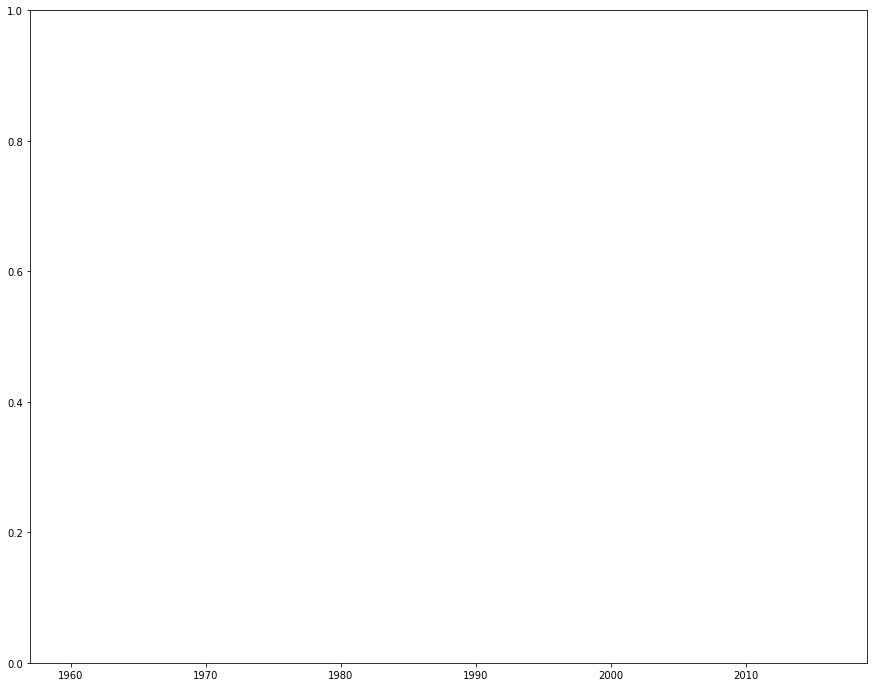

In [ ]:
temp_df = bigram_df[bigram_df['year']<2019]
fig, ax = plt.subplots(figsize=(15, 12))
sns.lineplot(x='year', y='count', hue='bigram', data=temp_df, 
             marker='o', lw=0.5)
plt.xlim(1957, 2019)
plt.show()

# Plot those related to the field

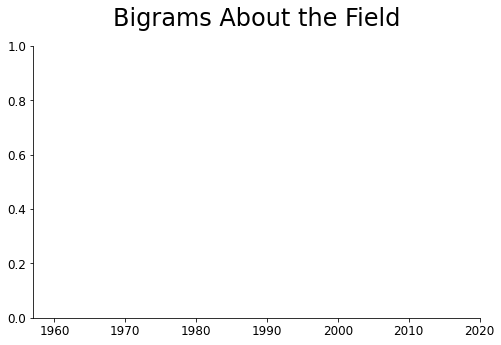

In [ ]:
temp_df = bigram_df[bigram_df['year']<2019]
temp_df = temp_df[temp_df['bigram'].isin(['behavior analysis', 'behavior analyst'])]
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='year', y='count', hue='bigram', data=temp_df, 
             marker='o', lw=0.5, palette='colorblind')
plt.xlim(1957, 2020)
plt.xticks(fontsize=12)
plt.xlabel("", fontsize=20, labelpad = 16)
plt.yticks(fontsize=12)
plt.ylabel("", fontsize=20, labelpad = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.title("Bigrams About the Field", fontsize=24, pad=20)
plt.show()

# Plot those related to behavior

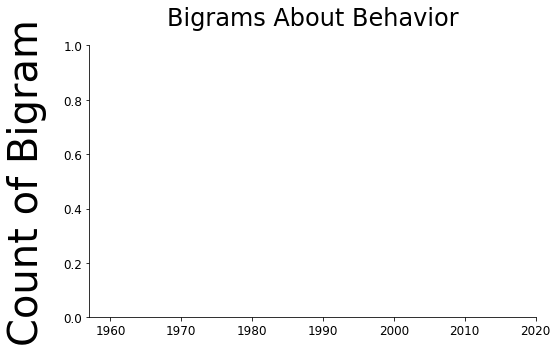

In [ ]:
temp_df = bigram_df[bigram_df['year']<2019]
temp_df = temp_df[temp_df['bigram'].isin(['response rate', 
                                          'problem behavior', 
                                          'verbal behavior', 
                                          'rate responding', 
                                          'correct response'])]
temp_df = temp_df.sort_values(by='bigram')
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='year', y='count', hue='bigram', data=temp_df, 
             marker='o', lw=0.5, 
             palette='colorblind')
plt.xlim(1957, 2020)
plt.xticks(fontsize=12)
plt.xlabel("", fontsize=20, labelpad = 16)
plt.yticks(fontsize=12)
plt.ylabel("Count of Bigram", fontsize=40, labelpad = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.title("Bigrams About Behavior", fontsize=24, pad=20)
plt.show()

# Plot those related to schedules

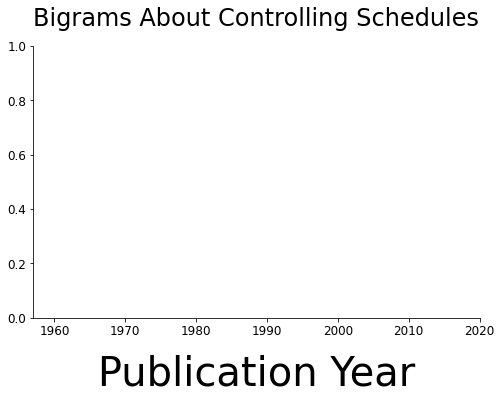

In [ ]:
temp_df = bigram_df[bigram_df['year']<2019]
temp_df = temp_df[temp_df['bigram'].isin(['stimulus control', 
                                          'functional analysis', 
                                          'multiple schedule', 
                                          'terminal link'])]
temp_df = temp_df.sort_values(by='bigram')
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x='year', y='count', hue='bigram', data=temp_df, 
             marker='o', lw=0.5, 
             palette='colorblind')
plt.xlim(1957, 2020)
plt.xticks(fontsize=12)
plt.xlabel("Publication Year", fontsize=40, labelpad = 16)
plt.yticks(fontsize=12)
plt.ylabel("", fontsize=20, labelpad = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.title("Bigrams About Controlling Schedules", fontsize=24, pad=20)
plt.show()

# Unigram barplot

In [ ]:
# Join all text in the datafrae
df_str = str([' '.join(data['lemmatization'])])
df_str = re.findall("\w+", df_str)

In [ ]:
data.word_count.sum()

60349701

In [ ]:
# Prep dataframe for unigrams
df_plot = Counter(ngrams(df_str, 1))
df_plot = pd.DataFrame.from_dict(df_plot, orient='index').reset_index()
df_plot.columns = ['unigram', 'count']

# Clean up for plotting
new_unigram = [] 
for i in range(len(df_plot)):
  val = str(df_plot['unigram'][i]).replace("'", "").replace("(", "").replace(")", "").replace(",", " ")
  new_unigram.append(val)
df_plot['unigram'] = new_unigram
df_plot

,unigram,count
0,journal,12451
1,effect,130927
2,concurrentchains,1828
3,procedure,93191
4,used,76601
...,...,...
239426,wwwhhsgovaboutnewshhs,1
239427,proposesnewrulesimproveinteroperabilityelectro...,1
239428,formationhtml,1
239429,intrasystem,1


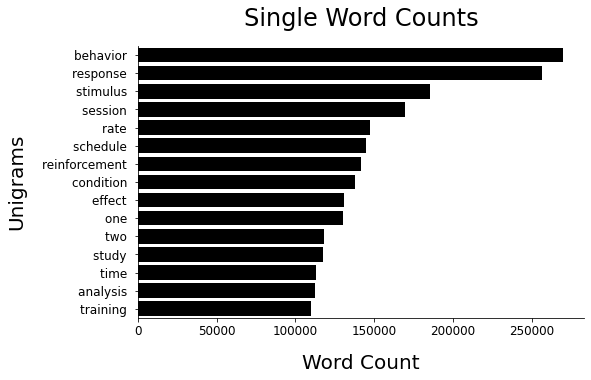

In [ ]:
# Plot it
temp_df = df_plot.sort_values(by='count', ascending=False)
temp_df = temp_df.iloc[:15, :]
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='count', y='unigram', data=temp_df, color='k')
plt.xticks(fontsize=12)
plt.xlabel("Word Count", fontsize=20, labelpad = 16)
plt.yticks(fontsize=12)
plt.ylabel("Unigrams", fontsize=20, labelpad = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Single Word Counts", fontsize=24, pad=20)
plt.show()

# Trigram barplot

In [ ]:
# Prep dataframe for unigrams
df_plot = Counter(ngrams(df_str, 3))
df_plot = pd.DataFrame.from_dict(df_plot, orient='index').reset_index()
df_plot.columns = ['trigrams', 'count']

# Clean up for plotting
new_unigram = [] 
for i in range(len(df_plot)):
  val = str(df_plot['trigrams'][i]).replace("'", "").replace("(", "").replace(")", "").replace(",", " ")
  new_unigram.append(val)
df_plot['trigrams'] = new_unigram
df_plot = df_plot.sort_values(by='count', ascending=False).reset_index(drop=True)
df_plot.head(20)

,trigrams,count
0,applied behavior analysis,4652
1,response per minute,3939
2,received acceptance journal,2907
3,last five session,2821
4,autism spectrum disorder,2213
5,sec sec sec,2033
6,accessed available http,1688
7,component multiple schedule,1663
8,experimental analysis behavior,1579
9,overall response rate,1515


In [ ]:
cut_list = ['received acceptance journal', 'sec sec sec', 'accessed available http']
new_tri = df_plot.iloc[:25, :]
new_tri = new_tri.drop([2, 5, 6, 16, 17, 18]).reset_index(drop=True)
new_tri

,trigrams,count
0,applied behavior analysis,4652
1,response per minute,3939
2,last five session,2821
3,autism spectrum disorder,2213
4,component multiple schedule,1663
5,experimental analysis behavior,1579
6,overall response rate,1515
7,functional communication training,1454
8,generalized matching law,1349
9,mean response rate,1341


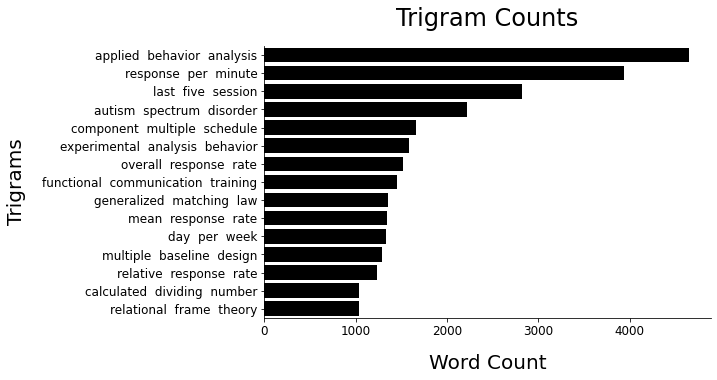

In [ ]:
# Plot it
temp_df = new_tri.sort_values(by='count', ascending=False)
temp_df = temp_df.iloc[:15, :]
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='count', y='trigrams', data=temp_df, color='k')
plt.xticks(fontsize=12)
plt.xlabel("Word Count", fontsize=20, labelpad = 16)
plt.yticks(fontsize=12)
plt.ylabel("Trigrams", fontsize=20, labelpad = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Trigram Counts", fontsize=24, pad=20)
plt.show()

In [ ]:
year = []
bigram = []
count = []
problems = []

for yr in list(range(1958, 2022)):
  try:
    temp_df = bg_year(data, yr).reset_index(drop=True)
    for i in range(len(temp_df)):
      val = str(temp_df['bigram'][i]).replace("'", "").replace("(", "").replace(")", "").replace(", ", " ")
      year.append(yr)
      bigram.append(val)
      count.append(temp_df['count'][i])
  except:
    problems.append(yr)
    print(f"Problem with {yr}...")

Problem with 1959...
Problem with 1960...
Problem with 1961...


In [ ]:
bigram_df = pd.DataFrame({'year': year, 
                          'trigram': bigram, 
                          'count': count})
bigram_df = bigram_df.sort_values(by=['year', 'count'], ascending=False)
bigram_df

,year,bigram,count
24543908,2021,limited health literacy,27
24547573,2021,floating catchment area,23
24547572,2021,twostep floating catchment,21
24543733,2021,patient health literacy,13
24543758,2021,natural language processing,13
...,...,...,...
258742,1958,exp rohles measurement,1
258743,1958,rohles measurement higher,1
258744,1958,higher intellectual functioning,1
258745,1958,intellectual functioning chimpanzee,1


In [ ]:
keep_trigrams = []

top_list = ['applied behavior analysis', 'response per minute', 'last five session', 
            'autism spectrum disorder', 'component multiple schedule', 
            'experimental analysis of behavior', 'overall response rate', 
            'functional communication training', 'generalized matching law', 
            'mean response rate', 'day per week', 'multiple baseline design', 
            'relative response rate', 'calculated dividing number', 'relational frame theory']

for item in top_list:
  clear_output()
  print(f"Working on {item}...")
  for i in range(len(bigram_df)):
    val = bigram_df['trigram'][i]
    if (item in val):
      keep_trigrams.append(i)

Working on relational frame theory...


In [ ]:
testing = bigram_df.iloc[keep_trigrams].reset_index(drop=True)
testing

,year,trigram,count
0,2020,applied behavior analysis,336
1,2019,applied behavior analysis,284
2,2018,applied behavior analysis,223
3,2017,applied behavior analysis,244
4,2016,applied behavior analysis,113
...,...,...,...
846,1995,relational frame theory,9
847,1994,relational frame theory,5
848,1993,relational frame theory,9
849,1991,relational frame theory,2


In [ ]:
drop_list = ['applied behavior analysisbased',  'educationapplied behavior analysis', 
             'educationapplied behavior analysis', 'eightcomponent multiple schedule',
             'fivecomponent multiple schedule', 'fourcomponent multiple schedule', 
             'groupmean response rate', 'mean response rateperminute', 
             'noncomponent multiple schedule',  'probemultiple baseline design',
             'quasimultiple baseline design', 'relational frame theoryresearch',
             'relative response ratesmin', 'safetyapplied behavior analysis',
             'safetyapplied behavior analysis', 'sevencomponent multiple schedule',
             'severalcomponent multiple schedule', 'shortcomponent multiple schedule',
             'sixcomponent multiple schedule', 'textbookapplied behavior analysis',
             'threecomponent multiple schedule', 'twocomponent multiple schedule',
             'unapplied behavior analysis', 'unequalcomponent multiple schedule', 
             'last five sessions', 'response per minutes', 'response per minutethe', 
             'multiple baseline designed', 'autism spectrum disorders']

keep_indices = []
for i in range(len(testing)):
  val = testing['trigram'][i]
  if val in drop_list:
    continue
  else:
    keep_indices.append(i)

testing = testing.iloc[keep_indices].reset_index(drop=True)
testing

,year,trigram,count
0,2020,applied behavior analysis,336
1,1994,applied behavior analysis,70
2,2017,applied behavior analysis,244
3,2016,applied behavior analysis,113
4,2015,applied behavior analysis,165
...,...,...,...
701,1981,response per minute,27
702,1980,response per minute,11
703,1979,response per minute,21
704,1978,response per minute,81


In [ ]:
testing = testing.sort_values(by=['trigram'])

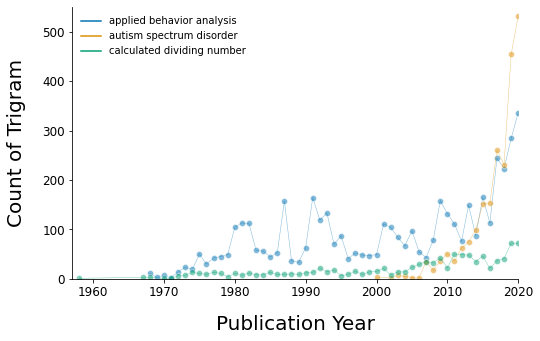

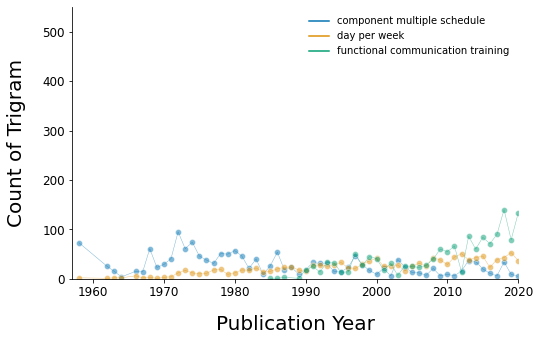

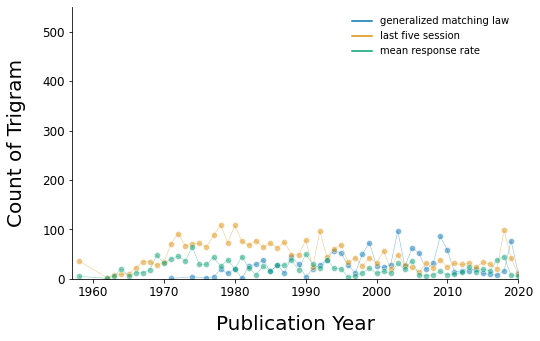

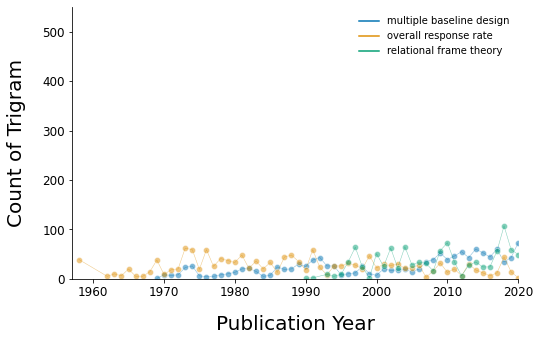

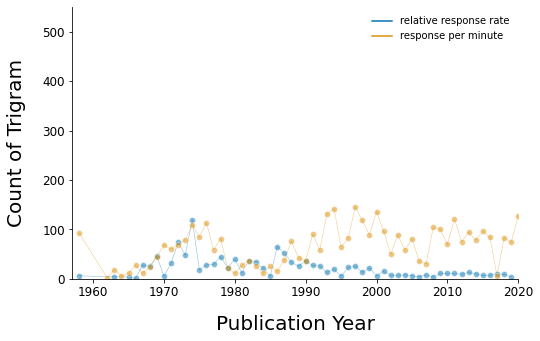

In [ ]:
start_index = 0
while start_index < len(testing['trigram'].unique()):
  vals = testing['trigram'].unique()[start_index:(start_index+3)]
  temp_df = testing[testing['trigram'].isin(vals)]
  fig, ax = plt.subplots(figsize=(8, 5))
  sns.lineplot(x='year', y='count', hue='trigram', data=temp_df, 
              marker='o', lw=0.5, 
              palette='colorblind', alpha=0.5)
  plt.xlim(1957, 2020)
  plt.xticks(fontsize=12)
  plt.xlabel("Publication Year", fontsize=20, labelpad = 16)
  plt.ylim(0, 550)
  plt.yticks(fontsize=12)
  plt.ylabel("Count of Trigram", fontsize=20, labelpad = 16)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.legend(frameon=False)
  plt.show()
  start_index += 3